S-learner
используем датасет из прошлой темы

In [9]:
# загружаем необходимые библиотеки
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

np.random.seed(1)

%matplotlib inline

In [10]:
# загружаем датафрейм
df = pd.read_csv("discountuplift.csv", sep="\t")
df.head(1).T

,0
recency,3.000000
history,977.510000
used_discount,1.000000
used_bogo,1.000000
is_referral,1.000000
treatment,0.000000
zip_code_Rural,0.000000
zip_code_Surburban,0.000000
zip_code_Urban,1.000000
channel_Multichannel,0.000000


In [11]:
df['target_class'].value_counts()

target_class
0    5688
2    5218
3    1174
1     704
Name: count, dtype: int64

Задание 1 из 4
Первое, что нужно сделать, — явно выделить колонки с целевой переменной, факторами и целевым воздействием. Напомним значения целевой переменной: 
 - 0 — контрольная выборка, не купили товар ($y_c=0$);
 - 1 — контрольная выборка, купили товар ($y_c=1$);
 - 2 — выборка с воздействием (скидка), не купили товар ($y_t=0$);
 - 3 — выборка с воздействием (скидка), купили товар ($y_t=1$).

Преобразуйте исходный датафрейм:
добавьте колонку old target — колонка, которая принимает значение 1, если была покупка, и 0 в противном случае;
выделим колонки с факторами и колонку с фактом «целевого воздействия» — выдачи скидки.

In [12]:
df["old_target"] = 0
df["old_target"][df.target_class == 1] = 1
df["old_target"][df.target_class == 3] = 1

In [13]:
feature_cols = ['recency', 'history', 'used_discount', 'used_bogo', 'is_referral',
                'zip_code_Rural', 'zip_code_Surburban', 'zip_code_Urban',
                'channel_Multichannel', 'channel_Phone', 'channel_Web']
target_col = "old_target"
treatment_col = 'treatment' 


df["old_target"].value_counts()

old_target
0    10906
1     1878
Name: count, dtype: int64

Вы видите явный дисбаланс. Это, в общем-то, ожидаемо, так как покупка — гораздо менее частотное событие,
чем показ или просмотр товара. С этим придётся работать.

Задание 2 из 4
Теперь разбейте выборку на тренировочную и тестовую. Условия: random_state=1, размер тестовой выборки — 25%, разбиение стратифицированное по колонке с фактом целевого воздействия и с целевой переменной.

In [14]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df,test_size=0.25,random_state=1,stratify=df[[treatment_col, target_col]])
df_train['old_target'].value_counts()

old_target
0    8180
1    1408
Name: count, dtype: int64

In [15]:
round(sum(df_train["old_target"] == 1) / len(df_train),5)

0.14685

In [16]:
round(sum(df_test["old_target"] == 1) / len(df_test),5)

0.14706

Задание 3 из 4
Теперь обучите S-learner (в данном случае это логистическая регрессия).

In [17]:
from sklearn.linear_model import LogisticRegression

s_learner = LogisticRegression()
s_learner.fit(X=df_train[feature_cols + [treatment_col]],
              y=df_train[target_col])

# посчитайте intercept
s_learner.intercept_

array([-1.15345971])

Задание 4 из 4
Финишная прямая! Измерьте качество модели при помощи Qini Score. В прекоде к этому заданию мы затронем все шаги — в будущем же вы сможете писать боее короткий код инференса модели. 

In [18]:
# предскажем вероятность покупки, если скидка есть
df_test[treatment_col] = 1
df_test["yes_treatment"] = s_learner.predict_proba(
    df_test[feature_cols + [treatment_col]]
)[:, 1]

# предскажите вероятность покупки, если скидки нет
df_test[treatment_col] = 0
df_test["no_treatment"] = s_learner.predict_proba(
    df_test[feature_cols + [treatment_col]]
)[:, 1]

df_test

,recency,history,used_discount,used_bogo,is_referral,treatment,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,...,channel_Web,proba_CN,proba_CR,proba_TN,proba_TR,uplift_score,target_class,old_target,yes_treatment,no_treatment
8348,9,718.64,1,0,1,0,1,0,0,1,...,0,0.554067,0.023504,0.352675,0.069754,0.248863,2,0,0.163836,0.100078
6137,4,135.53,0,1,0,0,0,0,1,0,...,0,0.509346,0.067572,0.290056,0.133027,0.394595,2,0,0.169592,0.103872
5198,4,98.09,0,1,0,0,0,1,0,0,...,0,0.419013,0.023046,0.449408,0.108532,0.284777,2,0,0.171729,0.105286
11830,4,102.07,0,1,1,0,1,0,0,0,...,0,0.414532,0.074022,0.403786,0.107660,0.117977,2,0,0.142589,0.086246
7148,4,929.49,0,1,1,0,0,0,1,0,...,0,0.476988,0.036499,0.440797,0.045717,0.045775,2,0,0.165916,0.101446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7008,5,55.83,1,0,0,0,1,0,0,0,...,1,0.266035,0.078418,0.502782,0.152766,0.010753,0,0,0.303947,0.198614
1445,5,337.42,1,1,0,0,0,0,1,1,...,0,0.395237,0.047588,0.332330,0.224845,0.592160,0,0,0.250565,0.159493
5369,10,162.84,1,0,0,0,0,0,1,0,...,0,0.501184,0.040953,0.397356,0.060507,0.113223,0,0,0.121825,0.072988
6318,9,29.99,0,1,1,0,0,1,0,0,...,1,0.454410,0.023769,0.457090,0.064731,0.148680,0,0,0.103297,0.061369


In [19]:
# реализуем подсчёт Qini Score:
def qini_df(df):
    # отранжируем выборку по значению uplift в порядке убывания 
    ranked = df.sort_values("uplift_score", ascending=False)
    
    N_c = sum(ranked['target_class'] <= 1)
    N_t = sum(ranked['target_class'] >= 2)
    
    # посчитаем в отсортированном датафрейме основные показатели, 
    # которые используются при расчёте Qini Score
    ranked['n_c1'] = 0
    ranked['n_t1'] = 0
    ranked.loc[ranked.target_class == 1,'n_c1'] = 1
    ranked.loc[ranked.target_class == 3,'n_t1'] = 1
    ranked['n_c1/nc'] = ranked.n_c1.cumsum() / N_c
    ranked['n_t1/nt'] = ranked.n_t1.cumsum() / N_t
    
    # посчитаем Qini-кривую и случайную прямую под ней
    ranked['uplift'] = round(ranked['n_t1/nt'] - ranked['n_c1/nc'],5)
    # добавим случайную кривую
    ranked['random_uplift'] = round(ranked["uplift_score"].rank(pct=True, ascending=False) * ranked['uplift'].iloc[-1],5)
    
    ranked["n"] = ranked["uplift_score"].rank(pct=True, ascending=False)
    # немного кода для визуализации
    plt.plot(ranked['n'], ranked['uplift'], color='r')
    plt.plot(ranked['n'], ranked['random_uplift'], color='b')
    plt.show()
    
    return (ranked['uplift'] - ranked['random_uplift']).sum()

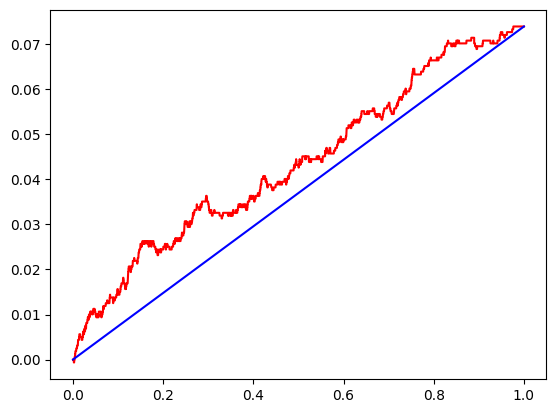

20.99648

In [20]:
uplift_vals = (
    df_test["yes_treatment"] - df_test["no_treatment"]
)  # посчитаем uplift на объектах тестовой выборки
df_test["uplift_score"] = uplift_vals

# посчитаем Qini Score по нашему датасету
qini_df(df_test)

In [21]:
ranked = df_test.sort_values("uplift_score", ascending=False)
    
N_c = sum(ranked['target_class'] <= 1)
N_t = sum(ranked['target_class'] >= 2)
    
    # посчитаем в отсортированном датафрейме основные показатели, 
    # которые используются при расчёте Qini Score
ranked['n_c1'] = 0
ranked['n_t1'] = 0
ranked.loc[ranked.target_class == 1,'n_c1'] = 1
ranked.loc[ranked.target_class == 3,'n_t1'] = 1
ranked['n_c1/nc'] = ranked.n_c1.cumsum() / N_c
ranked['n_t1/nt'] = ranked.n_t1.cumsum() / N_t
    


In [23]:
ranked.query('target_class==1 or target_class==3')

,recency,history,used_discount,used_bogo,is_referral,treatment,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,...,proba_TR,uplift_score,target_class,old_target,yes_treatment,no_treatment,n_c1,n_t1,n_c1/nc,n_t1/nt
1012,1,1820.49,1,0,1,0,0,1,0,0,...,0.018021,0.132396,1,1,0.446123,0.313727,1,0,0.000626,0.000000
1131,1,496.80,1,1,0,0,0,0,1,0,...,0.054585,0.129512,3,1,0.425270,0.295758,0,1,0.000626,0.000626
11805,1,406.75,1,1,0,0,0,1,0,0,...,0.168096,0.128742,3,1,0.420142,0.291400,0,1,0.000626,0.001252
3716,1,376.11,1,1,0,0,0,1,0,0,...,0.251254,0.127950,3,1,0.415026,0.287075,0,1,0.000626,0.001877
5632,1,431.98,1,1,0,0,0,0,1,0,...,0.102760,0.127857,3,1,0.414432,0.286575,0,1,0.000626,0.002503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8924,10,294.65,0,1,1,0,0,0,1,0,...,0.033510,0.030495,1,1,0.073704,0.043209,1,0,0.110138,0.181477
8703,10,225.74,0,1,1,0,0,1,0,0,...,0.016275,0.030321,3,1,0.073262,0.042941,0,1,0.110138,0.182103
8476,10,86.56,1,0,1,0,0,1,0,0,...,0.024020,0.029773,3,1,0.071875,0.042102,0,1,0.110138,0.182728
606,10,108.28,0,1,1,0,0,1,0,0,...,0.034435,0.028225,3,1,0.067972,0.039746,0,1,0.110138,0.183354
